In [53]:
from model import *
from optax import adam
from src.datagen import Equations
import os
from jax import jit, vmap, random, lax
import jax
import matplotlib.pyplot as plt
import seaborn as sns
import time
import scienceplots

jax.config.update("jax_enable_x64", True)
plt.style.use("science")

## Small System

In [54]:
state_variables = 2
expected_number_of_nls = 2
input_dim = state_variables * expected_number_of_nls
output_dim = state_variables

seed = 1
train_batch_size = 32
test_batch_size = 64

In [55]:
def generate_alphabeta(dim, num, seed):
    key = random.key(seed)
    A = random.normal(
        key, (max(num, dim), num)
    )  # Generate (max(num, dim), num)) random matrix
    Q, _, _ = jnp.linalg.svd(A, full_matrices=True)  # Get orthogonal matrix (num, num)
    return Q[:dim, :num] * 5.0


def generate_callable_functions(dim, num, seed):
    bases = generate_alphabeta(dim, num, seed)  # Get num basis vectors
    bases = bases.T
    alphas = bases[:, : dim // 2]  # First half of Q are alphas
    gammas = bases[:, dim // 2 :]

    def make_function(alpha, gamma):
        @jit
        def func(x):
            return (
                alpha[0] * nn.relu(x + gamma[0])
                + alpha[1] * nn.relu(x + gamma[1])
                + alpha[2] * nn.relu(x + gamma[2])
            )

        return func

    return tuple([make_function(alphas[i], gammas[i]) for i in range(num)]), bases

In [56]:
dims = 6
n_nls = expected_number_of_nls
alphagamma = generate_alphabeta(dims, n_nls, seed)
alphagamma = alphagamma.T
alphas = alphagamma[:, : dims // 2].T  # First half of Q are alphas
gammas = alphagamma[:, dims // 2 :].T
print(alphagamma.shape)
print("Alphas:", alphas)
print("Gammas:", gammas)

non_lins, vec_nls = generate_callable_functions(dims, n_nls, seed)

config = {
    "n_vars": state_variables,
    "n_eqs": state_variables,
    "bounds_addends": (1, 1),
    "bounds_multiplicands": (1, 1),
    "non_lins": non_lins,
    "sym_non_lins": None,
    "distribution": "uniform",
    "a": None,
    "b": None,
    "sigma": None,
    "p": None,
    "seed": seed,
}

(2, 6)
Alphas: [[-1.08309014 -2.21168528]
 [-2.49739684 -0.83931987]
 [ 3.06286834 -2.50490075]]
Gammas: [[-2.74435581 -1.63667395]
 [-0.80283658  0.93569595]
 [-0.18090586  3.09438751]]


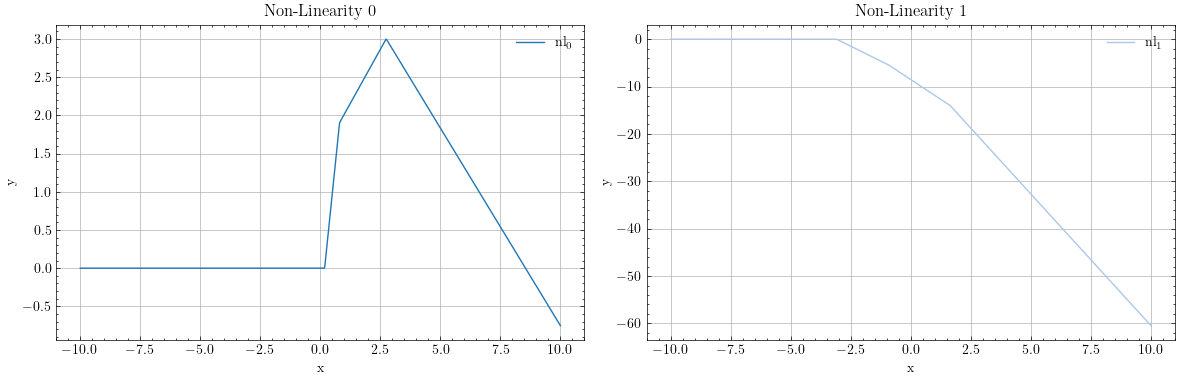

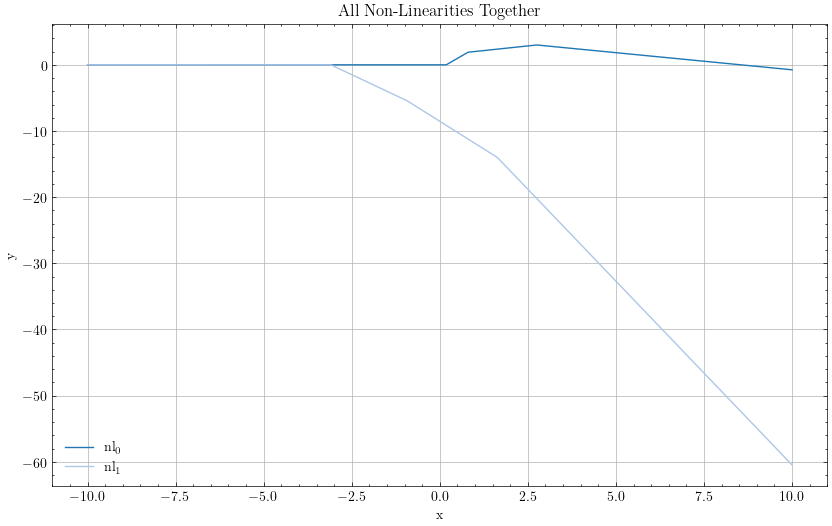

In [57]:
# Create subplots for individual non-linearities
num_funcs = len(non_lins)
cols = min(2, num_funcs)  # Number of columns in the grid, max 2
rows = (num_funcs + cols - 1) // cols  # Rows needed for individual plots

bound = 10
x = jnp.linspace(-bound, bound, 1000)
colors = plt.cm.tab20(range(num_funcs))  # Use a colormap to assign colors

# Handle different subplot configurations
if num_funcs == 1:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    axes = [ax]  # Make it iterable for the loop
elif num_funcs == 2:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
else:
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), sharex=True)
    axes = axes.flatten()  # Flatten for easier iteration

# Plot each callable's result in separate subplots
for i, func in enumerate(non_lins):
    ax = axes[i]
    y = func(x)
    ax.plot(x, y, label=r"$\text{nl}_{%d}$" % i, color=colors[i])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Non-Linearity {i}")
    ax.legend()
    ax.grid(True)

# Hide any empty subplots if num_funcs < rows*cols
for i in range(num_funcs, len(axes)):
    axes[i].set_visible(False)

# Adjust layout for individual plots
plt.tight_layout()
plt.show()
plt.clf()
plt.close()

# Create a separate figure for all non-linearities together
plt.figure(figsize=(10, 6))
for i, func in enumerate(non_lins):
    y = func(x)
    plt.plot(x, y, label=r"$\text{nl}_{%d}$" % i, color=colors[i])
plt.xlabel("x")
plt.ylabel("y")
plt.title("All Non-Linearities Together")
plt.legend()
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [58]:
system = Equations(config)
system.save_symb_expr()

System and state loaded from equations_75d01eefae0f6afb35893a5e92c006b3.pkl
PDF already exists


In [59]:
def my_eval(v):
    return system(y=v)

In [60]:
train_size = int(1e4)
test_ratio = 0.2
test_size = int(test_ratio * train_size)
total_size = train_size + test_size
train_values = jnp.tile(
    jnp.linspace(-1 * bound, bound, total_size).reshape(-1, 1), (1, config["n_eqs"])
)

# Randomly select `test_size` elements for inbound_test
key = random.key(seed)
key, subkey = random.split(key)  # Ensure reproducibility
indices = random.choice(
    subkey, total_size, shape=(test_size,), replace=False
)  # Unique indices
inbound_test = train_values[indices]  # Extract test points
mask = jnp.ones(total_size, dtype=bool)
mask = mask.at[indices].set(False)  # Mask out test points
train_values = train_values[mask]  # Remove test points from training set

# Create out-of-bound test values
range1 = jnp.linspace(-1 * bound - 5, -1 * bound, test_size // 2)
range2 = jnp.linspace(bound, bound + 5, test_size // 2)
outofbound_test = jnp.concatenate((range1, range2), axis=0).reshape(-1, 1)
outofbound_test = jnp.tile(outofbound_test, (1, config["n_eqs"]))

# Stack both test sets
stacked_test = jnp.vstack((inbound_test, outofbound_test))

# Concatenate train and test values
values = jnp.vstack((train_values, stacked_test))

# Standardize values
values_mean = jnp.mean(values, axis=0)
values_std = jnp.std(values, axis=0)


# Evaluate
evaluated_values = vmap(my_eval)(values)
# values = (values - values_mean) / values_std

# Standardize evaluated_values
evaluated_values_mean = jnp.mean(evaluated_values, axis=0)
evaluated_values_std = jnp.std(evaluated_values, axis=0)
evaluated_values = (evaluated_values - evaluated_values_mean) / evaluated_values_std

In [61]:
model = ZeroLayersNN(
    N=input_dim,
    L=expected_number_of_nls,
    output_dim=state_variables,
    y_mean=evaluated_values_mean,
    y_std=evaluated_values_std,
    nls_init=None,
    train_activations=True,
)
dummy_input = jnp.zeros((train_batch_size, input_dim))
key, subkey = random.split(key)
params = model.init(subkey, dummy_input)
optimizer = adam(learning_rate=0.001)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)
print(
    f"There are {count_params(state.params['params'])} learnable parameters in the current architecture."
)

There are 22 learnable parameters in the current architecture.


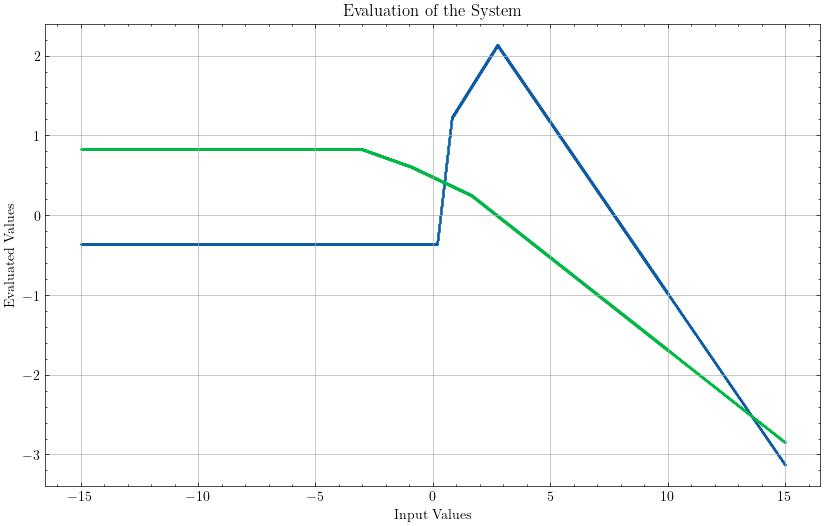

In [62]:
plt.figure(figsize=(10, 6))
for i in range(config["n_eqs"]):
    plt.scatter(values[:, 0], evaluated_values[:, i], label=f"Equation {i+1}", s=0.1)
plt.xlabel("Input Values")
plt.ylabel("Evaluated Values")
plt.title("Evaluation of the System")
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [63]:
expanded_values = jnp.repeat(values, expected_number_of_nls, axis=1)
train_values = expanded_values[:train_size]
inbound_test = expanded_values[train_size : test_size + train_size]
outofbound_test = expanded_values[test_size + train_size :]

train_outputs, inbound_test_outputs = (
    evaluated_values[:train_size],
    evaluated_values[train_size : test_size + train_size],
)
outofbound_test_outputs = evaluated_values[test_size + train_size :]

train_batches = create_batches(train_values, train_outputs, train_batch_size)
inbound_test_batches = create_batches(
    inbound_test, inbound_test_outputs, test_batch_size
)
outofbound_test_batches = create_batches(
    outofbound_test, outofbound_test_outputs, test_batch_size
)

In [64]:
vectors = jnp.concatenate(
    (
        state.params["params"]["CustomActivation_0"]["alpha"],
        state.params["params"]["CustomActivation_0"]["gamma"],
    ),
    axis=0,
).T
print(vectors)

[[ 0.00096107 -0.00473254  0.01686062  0.01718449  0.00476915  0.00890394]
 [-0.00859394 -0.00805257 -0.01322788  0.00209636 -0.02173789 -0.01482142]]


In [65]:
def make_training_functions(loss_fn):
    @jit
    def train_epoch(carry, epoch):
        state, _ = carry  # Unpack state and dummy loss accumulator
        epoch_loss = jnp.array(0.0)

        # Loop over batches
        def batch_step(carry, batch):
            state, _ = carry
            batch_x, batch_y = batch
            state, train_loss = train_step(state, batch_x, batch_y, loss_fn)
            inbound_test_loss = evaluate(state, inbound_test_batches, loss_fn)
            outofbound_test_loss = evaluate(state, outofbound_test_batches, loss_fn)

            return (state, train_loss), (
                train_loss,
                inbound_test_loss,
                outofbound_test_loss,
            )

        (state, _), (
            train_losses,
            inbound_test_losses,
            outofbound_test_losses,
        ) = lax.scan(batch_step, (state, 0.0), train_batches)

        # Print every n epochs
        print_condition = epoch % 50 == 0
        jax.lax.cond(
            print_condition,
            # True branch: print metrics
            lambda: jax.debug.print(
                "Epoch: {epoch}, Train Loss: {train_loss:.4e}, Inbound-Test Loss: {inbound_test_loss:.4e}, Outofbound-Test Loss: {outofbound_test_loss:.4e} ",
                epoch=epoch,
                train_loss=jnp.mean(train_losses),
                inbound_test_loss=jnp.mean(inbound_test_losses),
                outofbound_test_loss=jnp.mean(outofbound_test_losses),
            ),
            # False branch: do nothing
            lambda: None,
        )
        return (state, epoch_loss), (
            train_losses,
            inbound_test_losses,
            outofbound_test_losses,
        )

    return train_step, evaluate, train_epoch

In [66]:
@partial(jax.jit, static_argnums=(1))
def loss_fn0(params, apply_fn, batch_x, batch_y, vec_lambda=10.0):
    predictions = apply_fn(params, batch_x)
    mse_loss = jnp.mean((predictions - batch_y) ** 2)

    # Extract alpha and gamma from CustomActivation_0
    alpha = params["params"]["CustomActivation_0"]["alpha"]
    gamma = params["params"]["CustomActivation_0"]["gamma"]

    # Compute L2 distance to target vector
    vec_diff = (alpha - alphas) ** 2 + (gamma - gammas) ** 2
    vec_loss = jnp.sum(vec_diff)  # Sum of squared differences

    return mse_loss + vec_lambda * vec_loss


@partial(jax.jit, static_argnums=(1,))
def loss_fn1(params, apply_fn, batch_x, batch_y, vec_lambda=10.0, alpha_hyper=100.0):
    predictions = apply_fn(params, batch_x)
    mse_loss = jnp.mean((predictions - batch_y) ** 2)

    alpha = params["params"]["CustomActivation_0"]["alpha"]
    gamma = params["params"]["CustomActivation_0"]["gamma"]

    distances = (alpha - alphas) ** 2 + (gamma - gammas) ** 2
    sum_exp = jnp.sum(jnp.exp(-alpha_hyper * distances))
    vec_loss = jnp.log(1 + sum_exp)

    return mse_loss + vec_lambda * vec_loss


@partial(jax.jit, static_argnums=(1,))
def loss_fn2(params, apply_fn, batch_x, batch_y, vec_lambda=10.0, sigma=0.01):
    predictions = apply_fn(params, batch_x)
    mse_loss = jnp.mean((predictions - batch_y) ** 2)

    alpha = params["params"]["CustomActivation_0"]["alpha"]
    gamma = params["params"]["CustomActivation_0"]["gamma"]

    distances = (alpha - alphas) ** 2 + (gamma - gammas) ** 2
    sum_gauss = jnp.sum(jnp.exp(-distances / (2 * sigma**2))) / 3.0
    vec_loss = jnp.log(1 + sum_gauss)

    return mse_loss + vec_lambda * vec_loss


@partial(jax.jit, static_argnums=(1))
def loss_fn3(params, apply_fn, batch_x, batch_y, vec_lambda=10.0):
    predictions = apply_fn(params, batch_x)
    mse_loss = jnp.mean((predictions - batch_y) ** 2)

    # Extract alpha and gamma from CustomActivation_0
    alpha = params["params"]["CustomActivation_0"]["alpha"]
    gamma = params["params"]["CustomActivation_0"]["gamma"]

    # Compute L2 distance to target vector
    vec_diff = (alpha - alphas) ** 2 + (gamma - gammas) ** 2
    vec_loss = jnp.sum(jnp.log(1 + vec_diff))  # Product of squared differences

    return mse_loss + vec_lambda * vec_loss


@partial(jax.jit, static_argnums=(1,))
def loss_fn4(params, apply_fn, batch_x, batch_y, vec_lambda=10.0, beta=1.0):
    predictions = apply_fn(params, batch_x)
    mse_loss = jnp.mean((predictions - batch_y) ** 2)

    # Extract alpha and gamma from CustomActivation_0
    alpha = params["params"]["CustomActivation_0"]["alpha"]
    gamma = params["params"]["CustomActivation_0"]["gamma"]

    distances = (alpha - alphas) ** 2 + (gamma - gammas) ** 2

    # Compute soft assignment weights π
    logits = -beta * distances
    max_logit = jnp.max(logits)
    stable_logits = logits - max_logit  # For numerical stability
    exp_logits = jnp.exp(stable_logits)
    pi = exp_logits / jnp.sum(exp_logits)  # Softmax

    # Regularization term: sum(π * distances)
    vec_loss = jnp.sum(pi * distances)

    return mse_loss + vec_lambda * vec_loss


@partial(jax.jit, static_argnums=(1,))
def loss_fn5(
    params, apply_fn, batch_x, batch_y, vec_lambda=10.0, gamma=1.0, lambda_sparse=0.1
):
    predictions = apply_fn(params, batch_x)
    mse_loss = jnp.mean((predictions - batch_y) ** 2)

    # Extract alpha and gamma from CustomActivation_0
    alpha = params["params"]["CustomActivation_0"]["alpha"]
    gamma = params["params"]["CustomActivation_0"]["gamma"]

    distances = (alpha - alphas) ** 2 + (gamma - gammas) ** 2

    # Compute soft assignment weights π
    logits = -gamma * distances
    max_logit = jnp.max(logits)
    stable_logits = logits - max_logit  # For numerical stability
    exp_logits = jnp.exp(stable_logits)
    pi = exp_logits / jnp.sum(exp_logits)  # Softmax

    # Regularization term: sum(π * distances) + λ * sum(|π|)
    vec_loss = jnp.sum(pi * distances) + lambda_sparse * jnp.sum(jnp.abs(pi))

    return mse_loss + vec_lambda * vec_loss


@partial(jax.jit, static_argnums=(1,))
def loss_fn6(params, apply_fn, batch_x, batch_y, vec_lambda=10.0, mu=0.1):
    predictions = apply_fn(params, batch_x)
    mse_loss = jnp.mean((predictions - batch_y) ** 2)

    # Extract alpha, gamma, and gating logits from CustomActivation_0
    alpha = params["params"]["CustomActivation_0"]["alpha"]
    gamma = params["params"]["CustomActivation_0"]["gamma"]

    distances = (alpha - alphas) ** 2 + (gamma - gammas) ** 2
    logits = -gamma * distances
    # Compute softmax gating variables z (enforces sum(z)=1 and z≥0)
    max_logit = jnp.max(logits)
    stable_logits = logits - max_logit  # Numerical stability
    exp_logits = jnp.exp(stable_logits)
    z = exp_logits / jnp.sum(exp_logits)

    # Regularization term: sum(z * distances) + μ*(1 - sum(z²))
    reg_term1 = jnp.sum(z * distances)
    reg_term2 = mu * (1 - jnp.sum(z**2))
    vec_loss = reg_term1 + reg_term2

    return mse_loss + vec_lambda * vec_loss


@partial(jax.jit, static_argnums=(1))
def loss_fn7(params, apply_fn, batch_x, batch_y, lambda_cosine=10.0):
    predictions = apply_fn(params, batch_x)
    mse_loss = jnp.mean((predictions - batch_y) ** 2)

    alpha = params["params"]["CustomActivation_0"]["alpha"]
    gamma = params["params"]["CustomActivation_0"]["gamma"]

    # Normalize vectors separately
    alpha_norm = alpha / jnp.linalg.norm(alpha, axis=1, keepdims=True)
    gamma_norm = gamma / jnp.linalg.norm(gamma, axis=1, keepdims=True)

    # Compute cosine similarity matrices
    cosine_sim_alpha = alpha_norm @ alpha_norm.T
    cosine_sim_gamma = gamma_norm @ gamma_norm.T

    # Clustering loss: maximize cosine similarity
    cluster_loss = 1 - 0.5 * (jnp.mean(cosine_sim_alpha) + jnp.mean(cosine_sim_gamma))

    return mse_loss + lambda_cosine * cluster_loss


@partial(jax.jit, static_argnums=(1))
def loss_fn8(params, apply_fn, batch_x, batch_y, lambda_entropy=10.0):
    predictions = apply_fn(params, batch_x)
    mse_loss = jnp.mean((predictions - batch_y) ** 2)

    alpha = params["params"]["CustomActivation_0"]["alpha"]
    gamma = params["params"]["CustomActivation_0"]["gamma"]

    # Compute pairwise distances
    pairwise_distances_alpha = jnp.sum(
        (alpha[:, None, :] - alpha[None, :, :]) ** 2, axis=-1
    )
    pairwise_distances_gamma = jnp.sum(
        (gamma[:, None, :] - gamma[None, :, :]) ** 2, axis=-1
    )

    # Convert distances to probability distributions
    p_alpha = jax.nn.softmax(-pairwise_distances_alpha, axis=1)
    p_gamma = jax.nn.softmax(-pairwise_distances_gamma, axis=1)

    # Compute entropy loss
    entropy_loss = 1 - 0.5 * (
        jnp.sum(p_alpha * jnp.log(p_alpha + 1e-8))
        + jnp.sum(p_gamma * jnp.log(p_gamma + 1e-8))
    )

    return mse_loss + lambda_entropy * entropy_loss


@partial(jax.jit, static_argnums=(1))
def loss_fn9(params, apply_fn, batch_x, batch_y, lambda_repulsion=10.0):
    predictions = apply_fn(params, batch_x)
    mse_loss = jnp.mean((predictions - batch_y) ** 2)

    alpha = params["params"]["CustomActivation_0"]["alpha"]
    gamma = params["params"]["CustomActivation_0"]["gamma"]

    # Compute pairwise squared distances
    pairwise_distances_alpha = jnp.sum(
        (alpha[:, None, :] - alpha[None, :, :]) ** 2, axis=-1
    )
    pairwise_distances_gamma = jnp.sum(
        (gamma[:, None, :] - gamma[None, :, :]) ** 2, axis=-1
    )

    # Repulsion loss: push all but `n` vectors to be close
    repulsion_loss = 0.5 * (
        jnp.mean(jnp.exp(-pairwise_distances_alpha))
        + jnp.mean(jnp.exp(-pairwise_distances_gamma))
    )

    return mse_loss + lambda_repulsion * repulsion_loss


@partial(jax.jit, static_argnums=(1))
def loss_fn10(params, apply_fn, batch_x, batch_y, lambda_spectral=10.0, top_k=2):
    predictions = apply_fn(params, batch_x)
    mse_loss = jnp.mean((predictions - batch_y) ** 2)

    alpha = params["params"]["CustomActivation_0"]["alpha"]
    gamma = params["params"]["CustomActivation_0"]["gamma"]

    # Compute Gram matrices separately
    gram_alpha = alpha @ alpha.T
    gram_gamma = gamma @ gamma.T

    # Compute eigenvalues
    eigenvalues_alpha = jnp.linalg.eigvalsh(gram_alpha)
    eigenvalues_gamma = jnp.linalg.eigvalsh(gram_gamma)

    # Penalize small eigenvalues beyond top_k (encourages `top_k` clusters)
    spectral_loss = jnp.sum(eigenvalues_alpha[:-top_k]) + jnp.sum(
        eigenvalues_gamma[:-top_k]
    )

    return mse_loss + lambda_spectral * spectral_loss


@partial(jax.jit, static_argnums=(1))
def loss_fn11(params, apply_fn, batch_x, batch_y):
    predictions = apply_fn(params, batch_x)
    mse_loss = jnp.mean((predictions - batch_y) ** 2)
    return mse_loss

In [67]:
loss_functions = [
    loss_fn0,
    loss_fn1,
    loss_fn2,
    loss_fn3,
    loss_fn4,
    loss_fn5,
    loss_fn6,
    loss_fn7,
    loss_fn8,
    loss_fn9,
    loss_fn10,
    loss_fn11,
]

In [68]:
num_epochs = 101
n_runs = 2

all_train_losses = []
all_inbound_test_losses = []
all_outofbound_test_losses = []
all_vectors = []

for i in range(len(loss_functions)):
    temp_train_losses = []
    temp_inbound_test_losses = []
    temp_outofbound_test_losses = []
    temp_vectors = []

    train_step, evaluate, train_epoch = make_training_functions(loss_functions[i])
    for n in range(n_runs):
        print(f"Run {n} of loss {i}...")

        key = random.key(n)
        params = model.init(key, dummy_input)
        optimizer = adam(learning_rate=0.001)
        state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

        (state, loss), (
            train_losses,
            inbound_test_losses,
            outofbound_test_losses,
        ) = lax.scan(train_epoch, (state, 0.0), jnp.arange(num_epochs))

        jax.block_until_ready(state)
        print("Training complete!")

        temp_train_losses.append(train_losses.flatten())
        temp_inbound_test_losses.append(inbound_test_losses.flatten())
        temp_outofbound_test_losses.append(outofbound_test_losses.flatten())

        vectors = jnp.concatenate(
            (
                state.params["params"]["CustomActivation_0"]["alpha"],
                state.params["params"]["CustomActivation_0"]["gamma"],
            ),
            axis=0,
        ).T

        temp_vectors.append(vectors)
        print("\n\n")

    all_train_losses.append(jnp.array(temp_train_losses))
    all_inbound_test_losses.append(jnp.array(temp_inbound_test_losses))
    all_outofbound_test_losses.append(jnp.array(temp_outofbound_test_losses))
    all_vectors.append(jnp.array(temp_vectors))

    print("------------------------------------------------------")
    print("\n\n\n")

all_train_losses = jnp.array(all_train_losses)
all_inbound_test_losses = jnp.array(all_inbound_test_losses)
all_outofbound_test_losses = jnp.array(all_outofbound_test_losses)
all_vectors = jnp.array(all_vectors)

Run 0 of loss 0...
Epoch: 0, Train Loss: 1.3711e+01, Inbound-Test Loss: 2.1233e+02, Outofbound-Test Loss: 2.1403e+02 
Epoch: 50, Train Loss: 2.5043e-18, Inbound-Test Loss: 3.8000e-17, Outofbound-Test Loss: 1.6929e-16 
Epoch: 100, Train Loss: 1.4038e-09, Inbound-Test Loss: 2.1739e-08, Outofbound-Test Loss: 2.6555e-08 
Training complete!



Run 1 of loss 0...
Epoch: 0, Train Loss: 1.3768e+01, Inbound-Test Loss: 2.1324e+02, Outofbound-Test Loss: 2.2082e+02 
Epoch: 50, Train Loss: 1.0315e-19, Inbound-Test Loss: 1.5629e-18, Outofbound-Test Loss: 6.3664e-18 
Epoch: 100, Train Loss: 1.5589e-09, Inbound-Test Loss: 2.4251e-08, Outofbound-Test Loss: 3.0592e-08 
Training complete!



------------------------------------------------------




Run 0 of loss 1...
Epoch: 0, Train Loss: 2.8744e-02, Inbound-Test Loss: 4.4193e-01, Outofbound-Test Loss: 2.2131e+00 
Epoch: 50, Train Loss: 1.3170e-04, Inbound-Test Loss: 1.9950e-03, Outofbound-Test Loss: 8.0501e-04 
Epoch: 100, Train Loss: 1.1734e-04, Inbou

In [69]:
# Save the arrays in a compressed .npz file
# jnp.savez(
#     "Results/run_data_small.npz",
#     all_train_losses,
#     all_inbound_test_losses,
#     all_outofbound_test_losses,
#     all_vectors,
# )

# print("Losses data saved successfully in the Results directory.")

# # Load the arrays from the compressed .npz file
# loaded_data = jnp.load("Results/run_data.npz")
# all_train_losses = loaded_data["arr_0"]
# all_inbound_test_losses = loaded_data["arr_1"]
# all_outofbound_test_losses = loaded_data["arr_2"]
# all_vectors = loaded_data["arr_3"]

# print("Losses data loaded successfully from the Results directory.")

In [70]:
all_train_losses_mean = jnp.mean(all_train_losses, axis=1)
all_train_losses_std = jnp.std(all_train_losses, axis=1)

all_inbound_test_losses_mean = jnp.mean(all_inbound_test_losses, axis=1)
all_inbound_test_losses_std = jnp.std(all_inbound_test_losses, axis=1)

all_outofbound_test_losses_mean = jnp.mean(all_outofbound_test_losses, axis=1)
all_outofbound_test_losses_std = jnp.std(all_outofbound_test_losses, axis=1)

In [71]:
for i in range(all_train_losses_mean.shape[0]):
    print(
        f"Loss {i} reached a minimum value of {jnp.min(all_train_losses_mean[i]):.4e} while training, with an uncertainty of {all_train_losses_std[i,jnp.argmin(all_train_losses_mean)]:.4e}"
    )

    print(
        f"Loss {i} reached a minimum value of {jnp.min(all_inbound_test_losses_mean[i]):.4e} while testing inbound, with an uncertainty of {all_inbound_test_losses_std[i,jnp.argmin(all_inbound_test_losses_mean)]:.4e}"
    )

    print(
        f"Loss {i} reached a minimum value of {jnp.min(all_outofbound_test_losses_mean[i]):.4e} while testing outofbound, with an uncertainty of {all_outofbound_test_losses_std[i,jnp.argmin(all_outofbound_test_losses_mean)]:.4e}"
    )

    print("\n\n")

Loss 0 reached a minimum value of 7.1663e-33 while training, with an uncertainty of 8.5167e-34
Loss 0 reached a minimum value of 2.2699e-31 while testing inbound, with an uncertainty of 1.2123e-32
Loss 0 reached a minimum value of 8.3884e-31 while testing outofbound, with an uncertainty of 3.1541e-32



Loss 1 reached a minimum value of 3.0083e-05 while training, with an uncertainty of 3.9015e-06
Loss 1 reached a minimum value of 1.7920e-03 while testing inbound, with an uncertainty of 6.7725e-05
Loss 1 reached a minimum value of 6.7449e-04 while testing outofbound, with an uncertainty of 3.1978e-05



Loss 2 reached a minimum value of 3.0083e-05 while training, with an uncertainty of 3.9015e-06
Loss 2 reached a minimum value of 1.7920e-03 while testing inbound, with an uncertainty of 6.7725e-05
Loss 2 reached a minimum value of 6.7449e-04 while testing outofbound, with an uncertainty of 3.1978e-05



Loss 3 reached a minimum value of 6.8087e-21 while training, with an uncertainty of 7

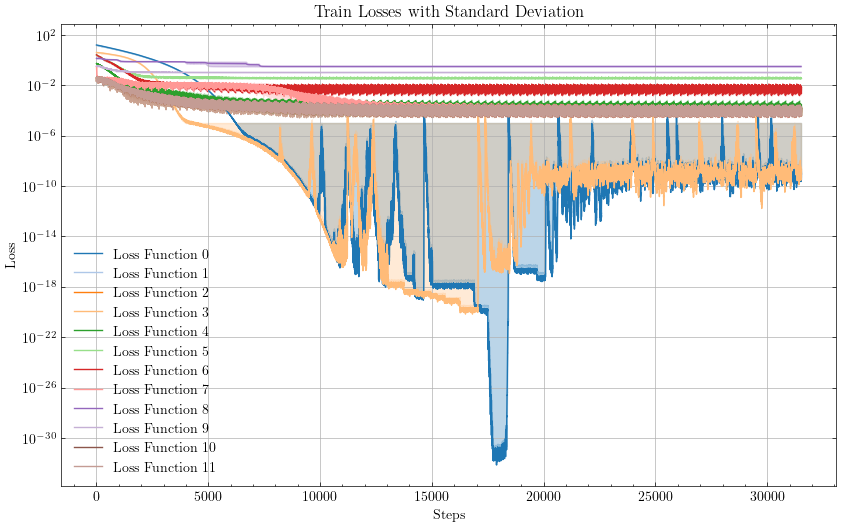

<Figure size 350x262.5 with 0 Axes>

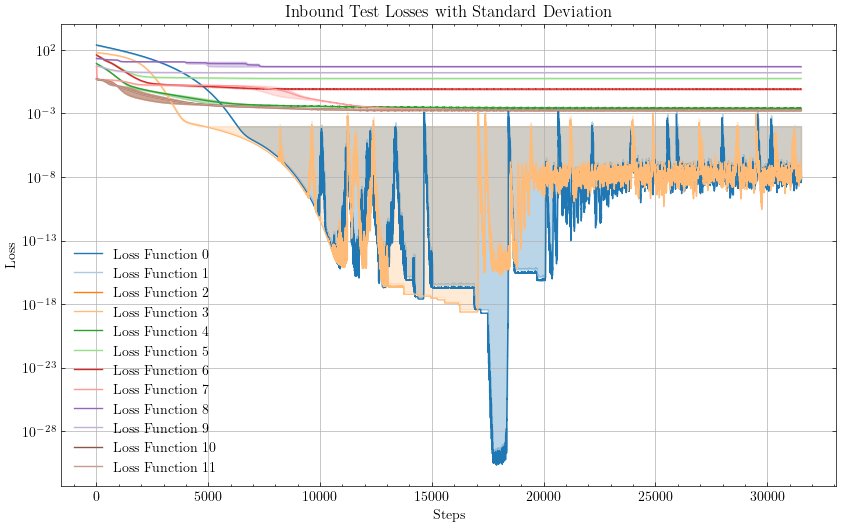

<Figure size 350x262.5 with 0 Axes>

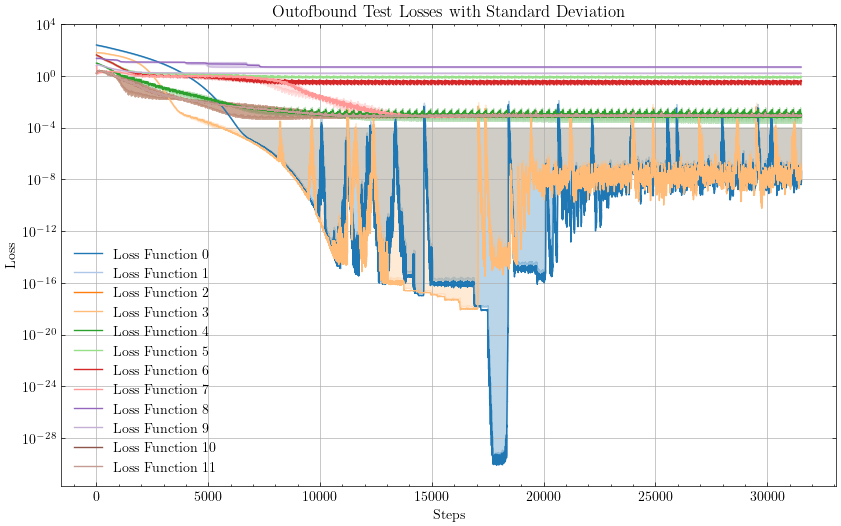

<Figure size 350x262.5 with 0 Axes>

In [72]:
# Plot the losses
train_steps = jnp.arange(len(train_losses))

plt.figure(figsize=(10, 6))
colors = plt.cm.tab20(range(all_train_losses_mean.shape[0]))  # Use tab20 colormap

for i in range(all_train_losses_mean.shape[0]):
    mean = all_train_losses_mean[i]
    std = all_train_losses_std[i]
    steps = jnp.arange(len(mean))

    plt.plot(steps, mean, label=f"Loss Function {i}", color=colors[i])
    plt.fill_between(
        steps, jnp.maximum(mean - std, 1e-5), mean + std, alpha=0.3, color=colors[i]
    )

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.yscale("log")
plt.title("Train Losses with Standard Deviation")
plt.grid(True)
plt.show()
plt.close()
plt.clf()


plt.figure(figsize=(10, 6))
colors = plt.cm.tab20(
    range(all_inbound_test_losses_mean.shape[0])
)  # Use tab20 colormap

for i in range(all_inbound_test_losses_mean.shape[0]):
    mean = all_inbound_test_losses_mean[i]
    std = all_inbound_test_losses_std[i]
    steps = jnp.arange(len(mean))

    plt.plot(steps, mean, label=f"Loss Function {i}", color=colors[i])
    plt.fill_between(
        steps, jnp.maximum(mean - std, 1e-4), mean + std, alpha=0.3, color=colors[i]
    )

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.yscale("log")
plt.title("Inbound Test Losses with Standard Deviation")
plt.grid(True)
plt.show()
plt.close()
plt.clf()


plt.figure(figsize=(10, 6))
colors = plt.cm.tab20(
    range(all_outofbound_test_losses_mean.shape[0])
)  # Use tab20 colormap

for i in range(all_outofbound_test_losses_mean.shape[0]):
    mean = all_outofbound_test_losses_mean[i]
    std = all_outofbound_test_losses_std[i]
    steps = jnp.arange(len(mean))

    plt.plot(steps, mean, label=f"Loss Function {i}", color=colors[i])
    plt.fill_between(
        steps, jnp.maximum(mean - std, 1e-4), mean + std, alpha=0.3, color=colors[i]
    )

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.yscale("log")
plt.title("Outofbound Test Losses with Standard Deviation")
plt.grid(True)
plt.show()
plt.close()
plt.clf()

In [73]:
# Initialize distance array
distances = jnp.zeros(
    (len(loss_functions), n_runs, n_nls)
)  # Shape: (m_losses, n_runs, n_vecs)

# Compute L2 distances (Euclidean)
for loss_idx in range(len(loss_functions)):
    for run_idx in range(n_runs):
        # Learned vectors for this (loss, run): shape (n_vecs, dim)
        learned_vectors = all_vectors[loss_idx, run_idx]

        # Compute pairwise distances between learned and true vectors
        # (diagonal since learned_vectors[i] corresponds to vec_nls[i])
        dist_matrix = jnp.sqrt(
            jnp.sum((learned_vectors[:, None, :] - vec_nls[None, :, :]) ** 2, axis=-1)
        )
        distances = distances.at[loss_idx, run_idx].set(jnp.diag(dist_matrix))

In [74]:
mean_distances = distances.mean(axis=(1, 2))  # Shape: (m_losses,)

mean_per_run = distances.mean(axis=2)  # Average over vectors first
std_distances = mean_per_run.std(axis=1)  # Std across runs

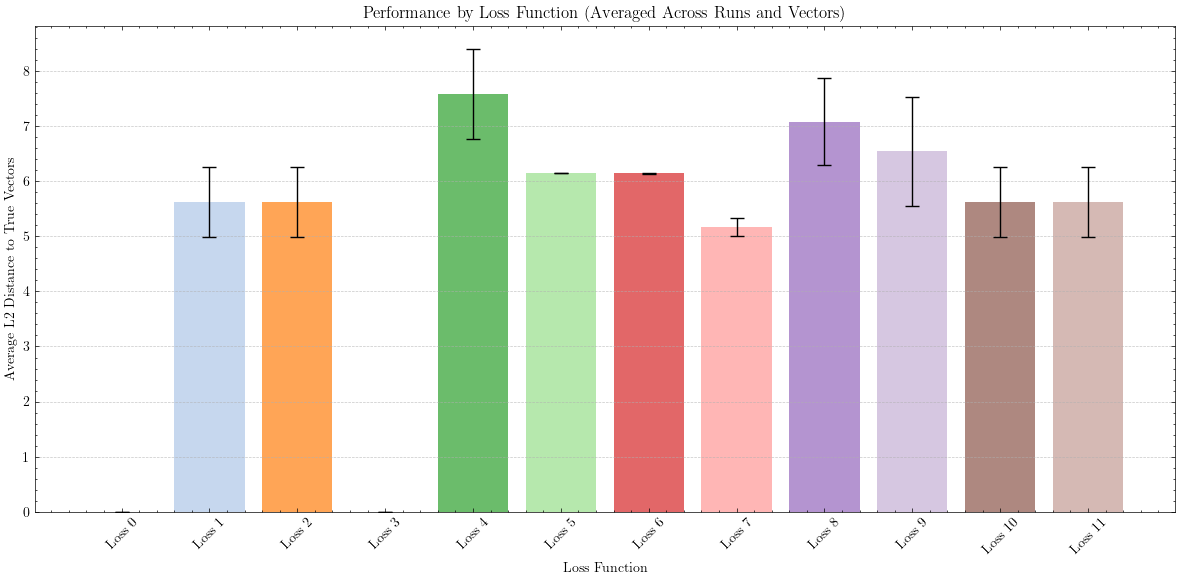

In [75]:
loss_names = [f"Loss {i}" for i in range(len(loss_functions))]

plt.figure(figsize=(12, 6))
plt.bar(
    loss_names, mean_distances, yerr=std_distances, capsize=5, alpha=0.7, color=colors
)
plt.xlabel("Loss Function")
plt.ylabel("Average L2 Distance to True Vectors")
plt.title("Performance by Loss Function (Averaged Across Runs and Vectors)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

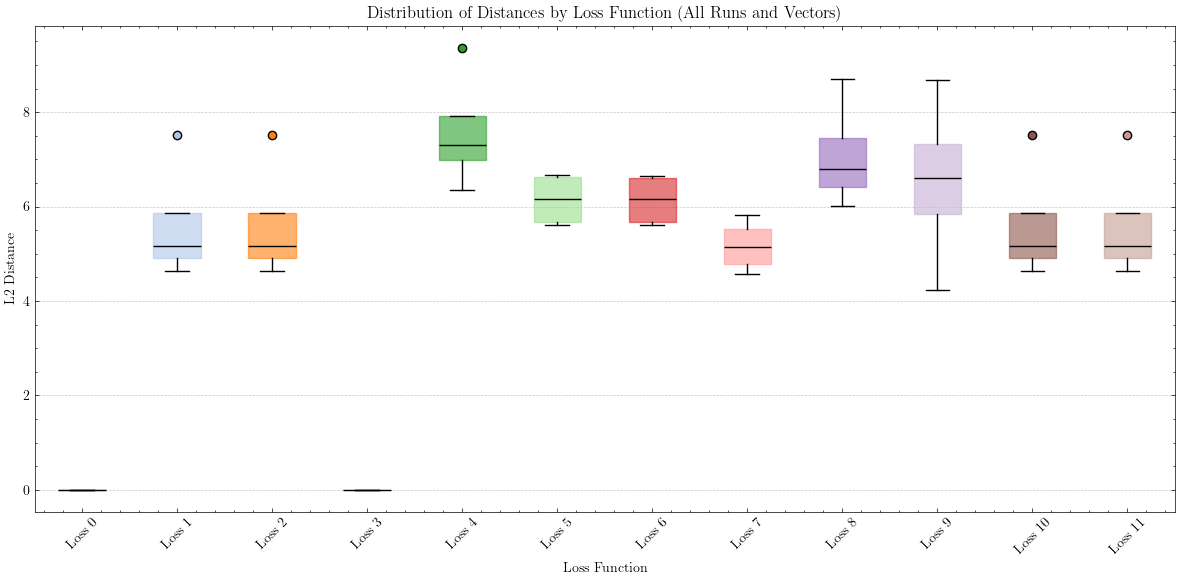

In [76]:
flattened_distances = distances.reshape(
    len(loss_functions), -1
).T  # Transpose for boxplot

plt.figure(figsize=(12, 6))
bp = plt.boxplot(flattened_distances, tick_labels=loss_names, patch_artist=True)

# Color each box with the corresponding color from the colormap
for i, box in enumerate(bp["boxes"]):
    box.set(facecolor=colors[i], alpha=0.6)  # Set box fill color with some transparency
    plt.setp(box, color=colors[i])  # Keep border black
    plt.setp(bp["whiskers"][i * 2 : i * 2 + 2], color="black")
    plt.setp(bp["caps"][i * 2 : i * 2 + 2], color="black")
    plt.setp(bp["medians"][i], color="black")
    plt.setp(bp["fliers"][i], markerfacecolor=colors[i], markeredgecolor="black")

plt.xlabel("Loss Function")
plt.ylabel("L2 Distance")
plt.title("Distribution of Distances by Loss Function (All Runs and Vectors)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Big System

In [25]:
state_variables = 20
expected_number_of_nls = 6
input_dim = state_variables * expected_number_of_nls
output_dim = state_variables

seed = 42
train_batch_size = 32
test_batch_size = 64

In [26]:
dims = 6
n_nls = expected_number_of_nls
alphagamma = generate_alphabeta(dims, n_nls, seed)
alphagamma = alphagamma.T
alphas = alphagamma[:, : dims // 2].T  # First half of Q are alphas
gammas = alphagamma[:, dims // 2 :].T
print(alphagamma.shape)
print("Alphas:", alphas)
print("Gammas:", gammas)

non_lins, vec_nls = generate_callable_functions(dims, n_nls, seed)

config = {
    "n_vars": state_variables,
    "n_eqs": state_variables,
    "bounds_addends": (1, 3),
    "bounds_multiplicands": (1, 1),
    "non_lins": non_lins,
    "sym_non_lins": None,
    "distribution": "uniform",
    "a": None,
    "b": None,
    "sigma": None,
    "p": None,
    "seed": seed,
}

(6, 6)
Alphas: [[ 0.144299    0.58959818 -0.41706515  0.54197418  0.40312056  0.03696285]
 [-0.35011789  0.1681633   0.41158723  0.09301065  0.1056639   0.81235379]
 [-0.12878433 -0.63038597  0.1775179   0.42229199  0.59692507 -0.14094486]]
Gammas: [[ 0.1495174  -0.37699648 -0.31030089  0.54582798 -0.5857379   0.31339191]
 [ 0.70515042  0.13460245  0.64988874  0.22732753 -0.07618197 -0.06934112]
 [ 0.56605414 -0.25780701 -0.32634031 -0.41191807  0.34801844  0.46457177]]


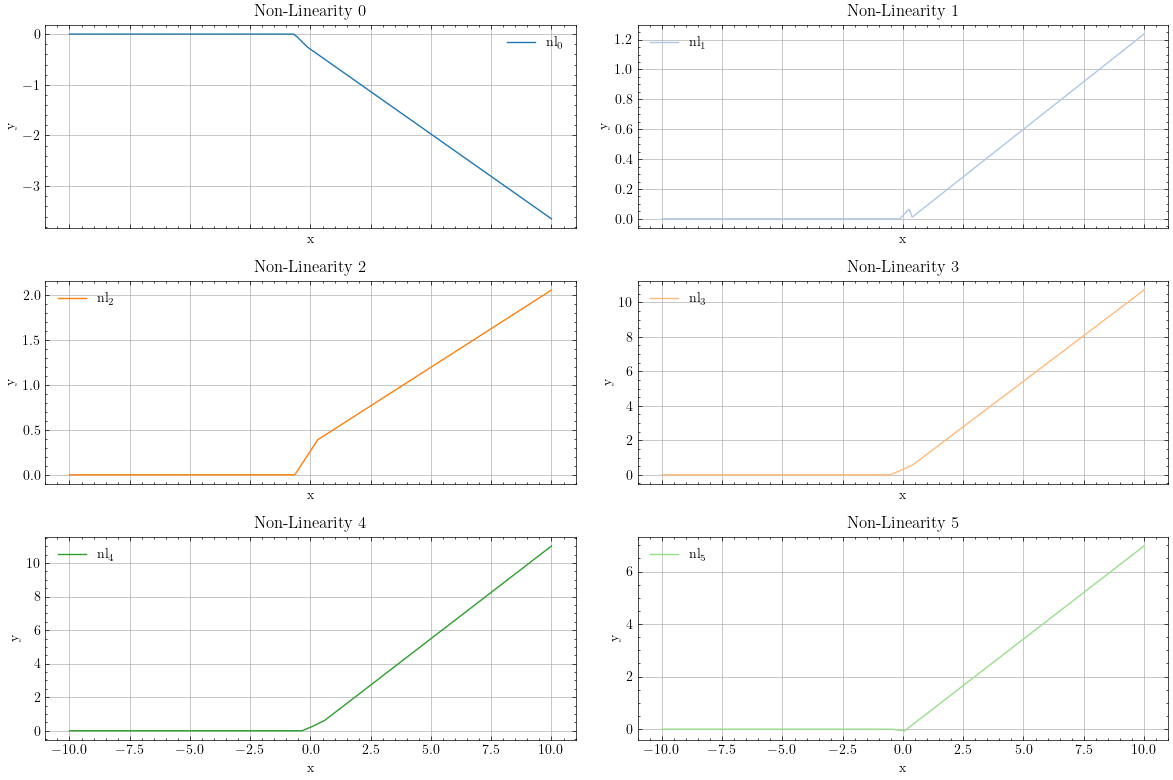

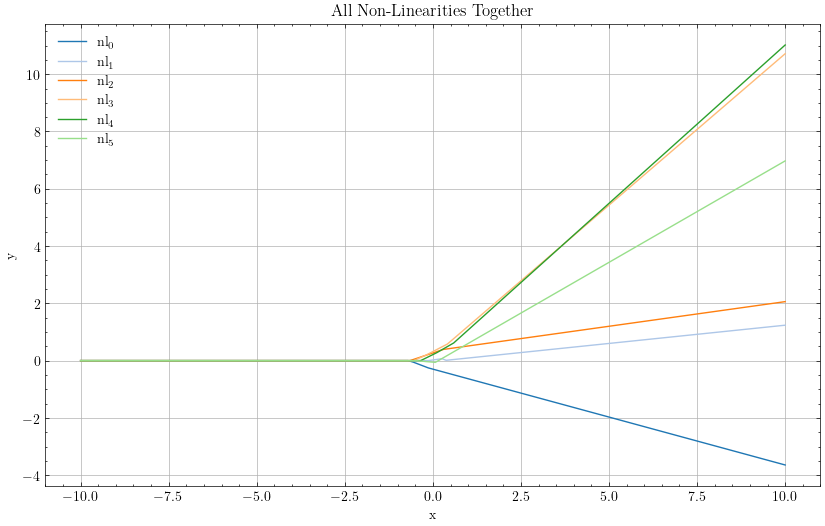

In [27]:
# Create subplots for individual non-linearities
num_funcs = len(non_lins)
cols = 2  # Number of columns in the grid
rows = (num_funcs + 1) // cols  # Rows for individual plots
fig, axes = plt.subplots(rows, cols, figsize=(12, 8), sharex=True)

bound = 10
x = jnp.linspace(-bound, bound, 1000)
colors = plt.cm.tab20(range(num_funcs))  # Use a colormap to assign colors

# Plot each callable's result in separate subplots
for i, func in enumerate(non_lins):
    row, col = divmod(i, cols)
    ax = axes[row, col]
    y = func(x)
    ax.plot(x, y, label=r"$\text{nl}_{%d}$" % i, color=colors[i])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Non-Linearity {i}")
    ax.legend()
    ax.grid(True)

# Adjust layout for individual plots
plt.tight_layout()
plt.show()
plt.clf()
plt.close()

# Create a separate figure for all non-linearities together
plt.figure(figsize=(10, 6))
for i, func in enumerate(non_lins):
    y = func(x)
    plt.plot(x, y, label=r"$\text{nl}_{%d}$" % i, color=colors[i])
plt.xlabel("x")
plt.ylabel("y")
plt.title("All Non-Linearities Together")
plt.legend()
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [28]:
system = Equations(config)
system.save_symb_expr()

System and state loaded from equations_27cab9850a25f443cceb8c2f462b2485.pkl
PDF already exists


In [29]:
def my_eval(v):
    return system(y=v)

In [30]:
train_size = int(1e4)
test_ratio = 0.2
test_size = int(test_ratio * train_size)
total_size = train_size + test_size
train_values = jnp.tile(
    jnp.linspace(-1 * bound, bound, total_size).reshape(-1, 1), (1, config["n_eqs"])
)

# Randomly select `test_size` elements for inbound_test
key = random.key(seed)
key, subkey = random.split(key)  # Ensure reproducibility
indices = random.choice(
    subkey, total_size, shape=(test_size,), replace=False
)  # Unique indices
inbound_test = train_values[indices]  # Extract test points
mask = jnp.ones(total_size, dtype=bool)
mask = mask.at[indices].set(False)  # Mask out test points
train_values = train_values[mask]  # Remove test points from training set

# Create out-of-bound test values
range1 = jnp.linspace(-1 * bound - 5, -1 * bound, test_size // 2)
range2 = jnp.linspace(bound, bound + 5, test_size // 2)
outofbound_test = jnp.concatenate((range1, range2), axis=0).reshape(-1, 1)
outofbound_test = jnp.tile(outofbound_test, (1, config["n_eqs"]))

# Stack both test sets
stacked_test = jnp.vstack((inbound_test, outofbound_test))

# Concatenate train and test values
values = jnp.vstack((train_values, stacked_test))

# Standardize values
values_mean = jnp.mean(values, axis=0)
values_std = jnp.std(values, axis=0)


# Evaluate
evaluated_values = vmap(my_eval)(values)
# values = (values - values_mean) / values_std

# Standardize evaluated_values
evaluated_values_mean = jnp.mean(evaluated_values, axis=0)
evaluated_values_std = jnp.std(evaluated_values, axis=0)
evaluated_values = (evaluated_values - evaluated_values_mean) / evaluated_values_std

In [31]:
model = ZeroLayersNN(
    N=input_dim,
    L=expected_number_of_nls,
    output_dim=state_variables,
    y_mean=evaluated_values_mean,
    y_std=evaluated_values_std,
    nls_init=None,
    train_activations=True,
)
dummy_input = jnp.zeros((train_batch_size, input_dim))
key, subkey = random.split(key)
params = model.init(subkey, dummy_input)
optimizer = adam(learning_rate=0.001)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)
print(
    f"There are {count_params(state.params['params'])} learnable parameters in the current architecture."
)

There are 2456 learnable parameters in the current architecture.


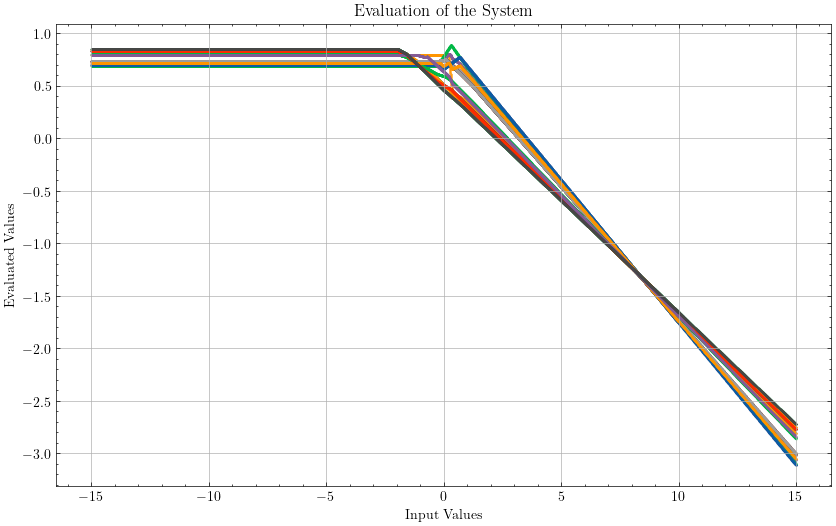

In [32]:
plt.figure(figsize=(10, 6))
for i in range(config["n_eqs"]):
    plt.scatter(values[:, 0], evaluated_values[:, i], label=f"Equation {i+1}", s=0.1)
plt.xlabel("Input Values")
plt.ylabel("Evaluated Values")
plt.title("Evaluation of the System")
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [33]:
expanded_values = jnp.repeat(values, expected_number_of_nls, axis=1)
train_values = expanded_values[:train_size]
inbound_test = expanded_values[train_size : test_size + train_size]
outofbound_test = expanded_values[test_size + train_size :]

train_outputs, inbound_test_outputs = (
    evaluated_values[:train_size],
    evaluated_values[train_size : test_size + train_size],
)
outofbound_test_outputs = evaluated_values[test_size + train_size :]

train_batches = create_batches(train_values, train_outputs, train_batch_size)
inbound_test_batches = create_batches(
    inbound_test, inbound_test_outputs, test_batch_size
)
outofbound_test_batches = create_batches(
    outofbound_test, outofbound_test_outputs, test_batch_size
)

In [34]:
vectors = jnp.concatenate(
    (
        state.params["params"]["CustomActivation_0"]["alpha"],
        state.params["params"]["CustomActivation_0"]["gamma"],
    ),
    axis=0,
).T
print(vectors)

[[ 0.00339199 -0.00953202  0.00858578  0.00983678 -0.01218916 -0.0059549 ]
 [-0.0026853  -0.00547562  0.00162093 -0.01068262  0.0019193  -0.010099  ]
 [-0.02096047  0.01208837  0.0092858  -0.01650443  0.00470693 -0.0085793 ]
 [ 0.01195003 -0.01977896  0.01128055  0.00138672  0.00299085  0.01062058]
 [-0.00323181  0.01057621  0.00442807 -0.00484772  0.02691803  0.00668709]
 [-0.00789798  0.00676083  0.01139568  0.00225851  0.0158971   0.01112422]]


In [35]:
all_train_losses = []
all_inbound_test_losses = []
all_outofbound_test_losses = []
all_vectors = []

for i in range(len(loss_functions)):
    temp_train_losses = []
    temp_inbound_test_losses = []
    temp_outofbound_test_losses = []
    temp_vectors = []

    train_step, evaluate, train_epoch = make_training_functions(loss_functions[i])
    for n in range(n_runs):
        print(f"Run {n} of loss {i}...")

        key = random.key(n)
        params = model.init(key, dummy_input)
        optimizer = adam(learning_rate=0.001)
        state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

        (state, loss), (
            train_losses,
            inbound_test_losses,
            outofbound_test_losses,
        ) = lax.scan(train_epoch, (state, 0.0), jnp.arange(num_epochs))

        jax.block_until_ready(state)
        print("Training complete!")

        temp_train_losses.append(train_losses.flatten())
        temp_inbound_test_losses.append(inbound_test_losses.flatten())
        temp_outofbound_test_losses.append(outofbound_test_losses.flatten())

        vectors = jnp.concatenate(
            (
                state.params["params"]["CustomActivation_0"]["alpha"],
                state.params["params"]["CustomActivation_0"]["gamma"],
            ),
            axis=0,
        ).T

        temp_vectors.append(vectors)
        print("\n\n")

    all_train_losses.append(jnp.array(temp_train_losses))
    all_inbound_test_losses.append(jnp.array(temp_inbound_test_losses))
    all_outofbound_test_losses.append(jnp.array(temp_outofbound_test_losses))
    all_vectors.append(jnp.array(temp_vectors))

    print("------------------------------------------------------")
    print("\n\n\n")

all_train_losses = jnp.array(all_train_losses)
all_inbound_test_losses = jnp.array(all_inbound_test_losses)
all_outofbound_test_losses = jnp.array(all_outofbound_test_losses)
all_vectors = jnp.array(all_vectors)

Run 0 of loss 0...
Epoch: 0, Train Loss: 6.5221e-03, Inbound-Test Loss: 1.0174e-01, Outofbound-Test Loss: 3.5441e-01 
Epoch: 50, Train Loss: 7.5856e-06, Inbound-Test Loss: 1.2060e-04, Outofbound-Test Loss: 3.4200e-05 
Epoch: 100, Train Loss: 5.4333e-06, Inbound-Test Loss: 8.8953e-05, Outofbound-Test Loss: 1.3164e-04 
Epoch: 150, Train Loss: 3.6509e-06, Inbound-Test Loss: 5.9941e-05, Outofbound-Test Loss: 8.3773e-05 
Epoch: 200, Train Loss: 2.5082e-06, Inbound-Test Loss: 3.9916e-05, Outofbound-Test Loss: 4.1599e-05 
Epoch: 250, Train Loss: 2.2005e-06, Inbound-Test Loss: 3.4538e-05, Outofbound-Test Loss: 3.7332e-05 
Epoch: 300, Train Loss: 2.0456e-06, Inbound-Test Loss: 3.2781e-05, Outofbound-Test Loss: 3.7031e-05 
Epoch: 350, Train Loss: 2.3797e-06, Inbound-Test Loss: 3.9564e-05, Outofbound-Test Loss: 6.9168e-05 
Epoch: 400, Train Loss: 1.9792e-06, Inbound-Test Loss: 3.2851e-05, Outofbound-Test Loss: 4.6016e-05 
Epoch: 450, Train Loss: 1.6102e-06, Inbound-Test Loss: 2.6819e-05, Outofbou

In [36]:
# Save the arrays in a compressed .npz file
jnp.savez(
    "Results/run_data_big.npz",
    all_train_losses,
    all_inbound_test_losses,
    all_outofbound_test_losses,
    all_vectors,
)

print("Losses data saved successfully in the Results directory.")

# # Load the arrays from the compressed .npz file
# loaded_data = jnp.load("Results/run_data.npz")
# all_train_losses = loaded_data["arr_0"]
# all_inbound_test_losses = loaded_data["arr_1"]
# all_outofbound_test_losses = loaded_data["arr_2"]
# all_vectors = loaded_data["arr_3"]

# print("Losses data loaded successfully from the Results directory.")

Losses data saved successfully in the Results directory.


In [37]:
all_train_losses_mean = jnp.mean(all_train_losses, axis=1)
all_train_losses_std = jnp.std(all_train_losses, axis=1)

all_inbound_test_losses_mean = jnp.mean(all_inbound_test_losses, axis=1)
all_inbound_test_losses_std = jnp.std(all_inbound_test_losses, axis=1)

all_outofbound_test_losses_mean = jnp.mean(all_outofbound_test_losses, axis=1)
all_outofbound_test_losses_std = jnp.std(all_outofbound_test_losses, axis=1)

In [38]:
for i in range(all_train_losses_mean.shape[0]):
    print(
        f"Loss {i} reached a minimum value of {jnp.min(all_train_losses_mean[i]):.4e} while training, with an uncertainty of {all_train_losses_std[i,jnp.argmin(all_train_losses_mean)]:.4e}"
    )

    print(
        f"Loss {i} reached a minimum value of {jnp.min(all_inbound_test_losses_mean[i]):.4e} while testing inbound, with an uncertainty of {all_inbound_test_losses_std[i,jnp.argmin(all_inbound_test_losses_mean)]:.4e}"
    )

    print(
        f"Loss {i} reached a minimum value of {jnp.min(all_outofbound_test_losses_mean[i]):.4e} while testing outofbound, with an uncertainty of {all_outofbound_test_losses_std[i,jnp.argmin(all_outofbound_test_losses_mean)]:.4e}"
    )

    print("\n\n")

Loss 0 reached a minimum value of 2.1649e-07 while training, with an uncertainty of 2.0728e-06
Loss 0 reached a minimum value of 1.7790e-05 while testing inbound, with an uncertainty of 6.6492e-05
Loss 0 reached a minimum value of 3.1208e-06 while testing outofbound, with an uncertainty of 2.1445e-04



Loss 1 reached a minimum value of 4.9576e-06 while training, with an uncertainty of 7.5674e-06
Loss 1 reached a minimum value of 1.8971e-04 while testing inbound, with an uncertainty of 9.8410e-05
Loss 1 reached a minimum value of 6.6834e-05 while testing outofbound, with an uncertainty of 7.0838e-04



Loss 2 reached a minimum value of 1.0339e-05 while training, with an uncertainty of 1.2632e-05
Loss 2 reached a minimum value of 2.6390e-04 while testing inbound, with an uncertainty of 1.7272e-04
Loss 2 reached a minimum value of 1.2410e-04 while testing outofbound, with an uncertainty of 2.6906e-02



Loss 3 reached a minimum value of 2.1690e-07 while training, with an uncertainty of 1

/Users/matteogallo/miniforge3/envs/metis_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


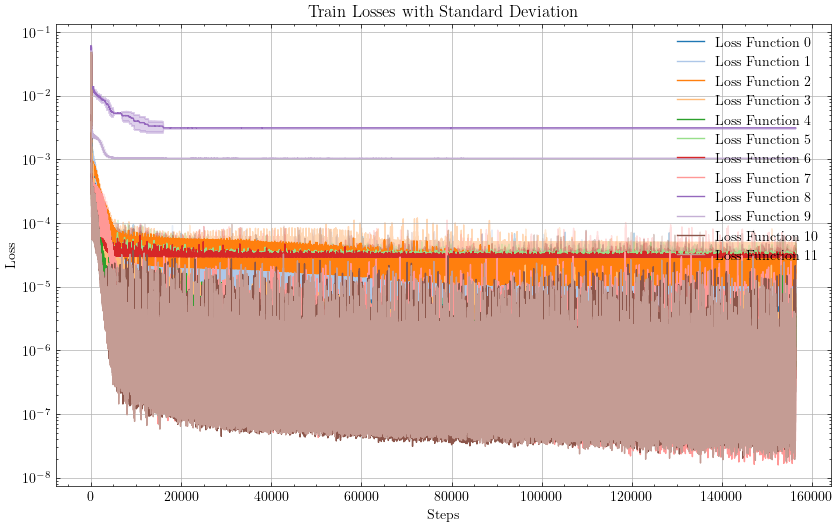

<Figure size 350x262.5 with 0 Axes>

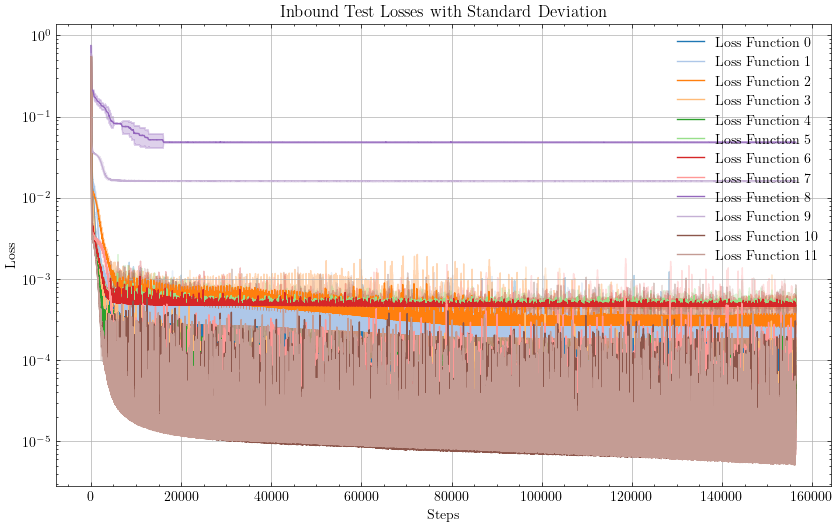

<Figure size 350x262.5 with 0 Axes>

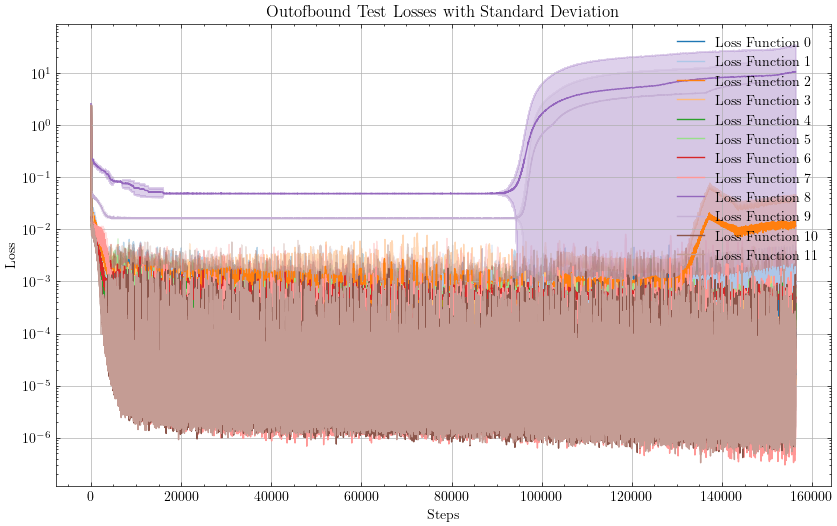

<Figure size 350x262.5 with 0 Axes>

In [39]:
# Plot the losses
train_steps = jnp.arange(len(train_losses))

plt.figure(figsize=(10, 6))
colors = plt.cm.tab20(range(all_train_losses_mean.shape[0]))  # Use tab20 colormap

for i in range(all_train_losses_mean.shape[0]):
    mean = all_train_losses_mean[i]
    std = all_train_losses_std[i]
    steps = jnp.arange(len(mean))

    plt.plot(steps, mean, label=f"Loss Function {i}", color=colors[i])
    plt.fill_between(
        steps, jnp.maximum(mean - std, 1e-5), mean + std, alpha=0.3, color=colors[i]
    )

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.yscale("log")
plt.title("Train Losses with Standard Deviation")
plt.grid(True)
plt.show()
plt.close()
plt.clf()


plt.figure(figsize=(10, 6))
colors = plt.cm.tab20(
    range(all_inbound_test_losses_mean.shape[0])
)  # Use tab20 colormap

for i in range(all_inbound_test_losses_mean.shape[0]):
    mean = all_inbound_test_losses_mean[i]
    std = all_inbound_test_losses_std[i]
    steps = jnp.arange(len(mean))

    plt.plot(steps, mean, label=f"Loss Function {i}", color=colors[i])
    plt.fill_between(
        steps, jnp.maximum(mean - std, 1e-4), mean + std, alpha=0.3, color=colors[i]
    )

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.yscale("log")
plt.title("Inbound Test Losses with Standard Deviation")
plt.grid(True)
plt.show()
plt.close()
plt.clf()


plt.figure(figsize=(10, 6))
colors = plt.cm.tab20(
    range(all_outofbound_test_losses_mean.shape[0])
)  # Use tab20 colormap

for i in range(all_outofbound_test_losses_mean.shape[0]):
    mean = all_outofbound_test_losses_mean[i]
    std = all_outofbound_test_losses_std[i]
    steps = jnp.arange(len(mean))

    plt.plot(steps, mean, label=f"Loss Function {i}", color=colors[i])
    plt.fill_between(
        steps, jnp.maximum(mean - std, 1e-4), mean + std, alpha=0.3, color=colors[i]
    )

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.yscale("log")
plt.title("Outofbound Test Losses with Standard Deviation")
plt.grid(True)
plt.show()
plt.close()
plt.clf()

In [40]:
# Initialize distance array
distances = jnp.zeros(
    (len(loss_functions), n_runs, n_nls)
)  # Shape: (m_losses, n_runs, n_vecs)

# Compute L2 distances (Euclidean)
for loss_idx in range(len(loss_functions)):
    for run_idx in range(n_runs):
        # Learned vectors for this (loss, run): shape (n_vecs, dim)
        learned_vectors = all_vectors[loss_idx, run_idx]

        # Compute pairwise distances between learned and true vectors
        # (diagonal since learned_vectors[i] corresponds to vec_nls[i])
        dist_matrix = jnp.sqrt(
            jnp.sum((learned_vectors[:, None, :] - vec_nls[None, :, :]) ** 2, axis=-1)
        )
        distances = distances.at[loss_idx, run_idx].set(jnp.diag(dist_matrix))

In [41]:
mean_distances = distances.mean(axis=(1, 2))  # Shape: (m_losses,)

mean_per_run = distances.mean(axis=2)  # Average over vectors first
std_distances = mean_per_run.std(axis=1)  # Std across runs

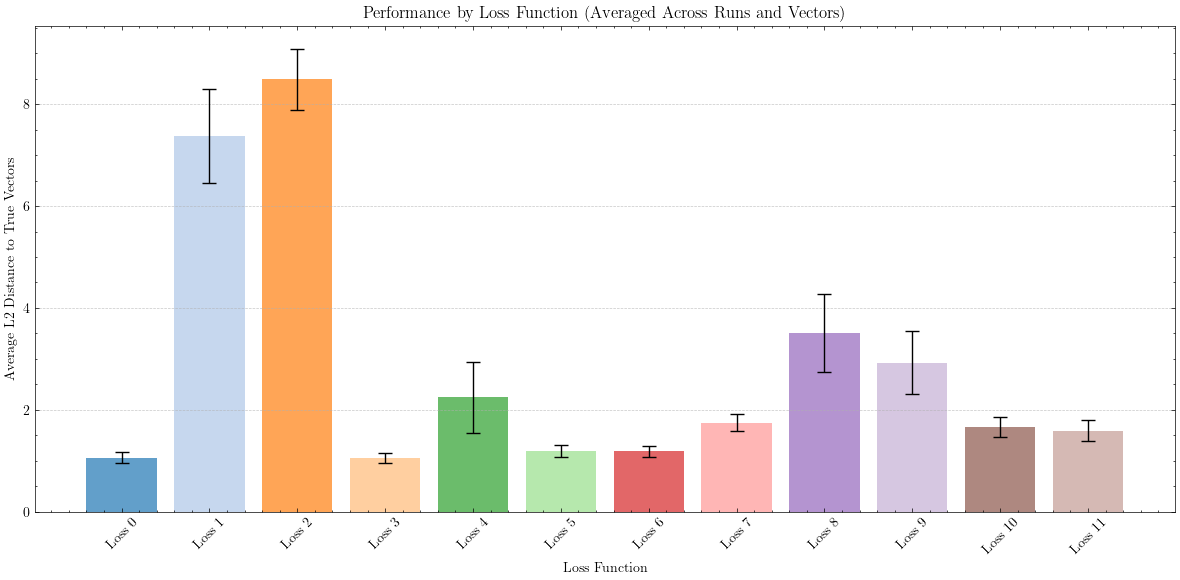

In [42]:
loss_names = [f"Loss {i}" for i in range(len(loss_functions))]

plt.figure(figsize=(12, 6))
plt.bar(
    loss_names,
    mean_distances,
    yerr=std_distances,
    capsize=5,
    alpha=0.7,
    color=colors,
)
plt.xlabel("Loss Function")
plt.ylabel("Average L2 Distance to True Vectors")
plt.title("Performance by Loss Function (Averaged Across Runs and Vectors)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

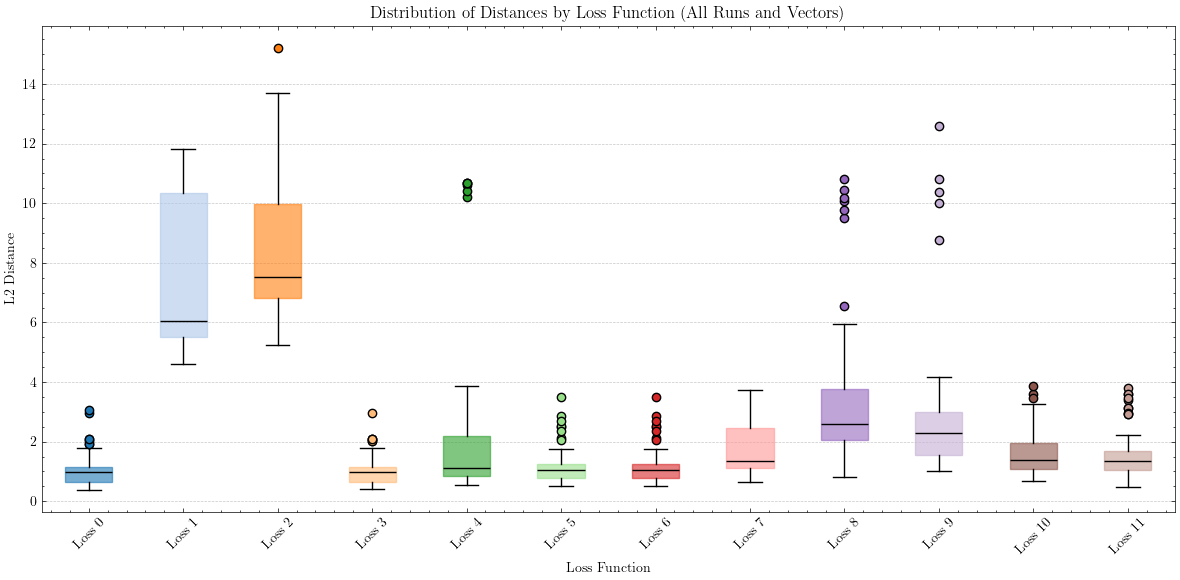

In [43]:
flattened_distances = distances.reshape(
    len(loss_functions), -1
).T  # Transpose for boxplot

plt.figure(figsize=(12, 6))
bp = plt.boxplot(flattened_distances, tick_labels=loss_names, patch_artist=True)

# Color each box with the corresponding color from the colormap
for i, box in enumerate(bp["boxes"]):
    box.set(facecolor=colors[i], alpha=0.6)  # Set box fill color with some transparency
    plt.setp(box, color=colors[i])  # Keep border black
    plt.setp(bp["whiskers"][i * 2 : i * 2 + 2], color="black")
    plt.setp(bp["caps"][i * 2 : i * 2 + 2], color="black")
    plt.setp(bp["medians"][i], color="black")
    plt.setp(bp["fliers"][i], markerfacecolor=colors[i], markeredgecolor="black")

plt.xlabel("Loss Function")
plt.ylabel("L2 Distance")
plt.title("Distribution of Distances by Loss Function (All Runs and Vectors)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()